# <center> Personalized Cancer Diagnosis
## Description
A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). As not all mutations lead to cancer.

Due to a mutation in a gene, there is some genetic variation developed in a gene. But the question comes, from which particular mutation this genetic variation happened in a gene. Currently this interpretation of genetic mutations is being done manually which is a very time-consuming task. Based on a gene and a variation in it, a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

## Business Problem
The workflow is as follows:

1. A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze.

2. The molecular pathologist searches for evidence in the medical literature that somehow are relevant to the genetic variations of interest.

3. Finally, this molecular pathologist spends a huge amount of time analyzing the evidence related to each of the variations to classify them into any one of the 9 different classes.

Our goal here is to replace step 3 by a machine learning model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. But the last step, which is also the most time consuming, will be fully automated by a machine learning model.

## Problem Statement
Classify the given genetic variations/mutations based on evidence from text-based clinical literature. In this problem, we need to find the mutation-type given the gene, variation and some text data from published research.

## Source of Data
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

## Real-world/Business objectives and constraints.
- No low-latency requirement.
- Interpretability is important.
- Errors can be very costly.
- Probability of a data-point belonging to each class is needed.

### Machine Learning Problem Formulation

#### Data Overview
- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations. Both these data files are have a common column called ID.

Data file's information:

- training_variants (ID , Gene, Variations, Class)
- training_text (ID, Text)

### Mapping the real-world problem to an ML problem

#### Type of Machine Learning Problem
- There are nine different classes a genetic mutation can be classified into Multi class classification problem

#### Performance Metric
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s):
- Multi class log-loss
- Confusion matrix

#### File Descriptions
<h6>TrainingData</h6> - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)

<h6>TrainingText</h6> - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

#### Train, CV and Test Datasets
Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import re
import time
import warnings
import numpy as np
import seaborn as sns
from sklearn import *
from collections import Counter,defaultdict
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,normalized_mutual_info_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.linear_model import SGDClassifier,LogisticRegression

from scipy.sparse import hstack 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import texthero as hero

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold

import math
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

warnings.filterwarnings("ignore")

### training/variants is CSV File Containing Data About Gentic Mutations used for Training 
#### Features Are:
#####  1.) ID: the id of the row used to link mutation to clinical evidence 
#####  2.) Gene: the gene where this gentic mutation is located
#####  3.) Variation: the amino-acid change for this mutations
#####  4.) Class: 1-9 class this gentic mutation has been classified on

In [2]:
# Training Variants

df_variants=pd.read_csv('/Users/DEV/Desktop/ML-Projects/cancer_classification/data/training_variants')
print(df_variants.head(3))
print(df_variants.shape)

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
(3321, 4)


In [3]:
# Converting text data into Dataframe

df_txt=pd.read_csv('/Users/DEV/Desktop/ML-Projects/cancer_classification/data/training_text',
                  sep="\|\|", engine='python',
                  names=['ID', 'text'],skiprows=1                                           )

df_txt.sample(3)

,ID,text
3007,3007,Purpose KIT is the major oncogenic driver of...
94,94,"Very recently, heterozygous mutations in the g..."
2848,2848,Twenty percent of individuals with a strong fa...


### Text Preprocessing

In [4]:
stop_words= set(stopwords.words('english')) # stop-words loading

def txt_process(text, index, col):
    if type(text) is str :
        string=""
        
        #replacing special characters with space
        text= re.sub('[^a-zA-Z0-9\n]',' ',text)
        
        #repacing muitiple spaces with single space
        text= re.sub('\s+',' ', text)
        
        #convert all letters into lower-case
        text= text.lower()
        
        for word in text.split():
            if word is not stop_words:
                string += word + " "
        
        df_txt[col][index]= string


In [5]:
for index, row in df_txt.iterrows():
    if type( row['text'] is not str):
        txt_process(row['text'], index, 'text')
    else:
        print("there's no text description for id:", index)

In [6]:
df_final= pd.merge(df_variants, df_txt, on='ID', how='left' )
df_final.sample(3)

,ID,Gene,Variation,Class,text
638,638,CDKN1B,Deletion,4,introduction a series of cyclin and cyclin dep...
1502,1502,FGFR4,V550E,7,rhabdomyosarcoma rms is a childhood cancer ori...
1254,1254,PIK3R1,E137K,1,abstract bladder cancers commonly show genetic...


In [7]:
# Handling Null values

df_final.isnull().sum()
df_final[df_final.isnull().any(axis=1)]
df_final.dropna(inplace=True)

### Train-Test Split

In [8]:
y=df_final.drop(['Variation','Gene','ID','text'],axis=1)
x=df_final.drop(['Class'],axis=1)

# train-test split by maintaing same distribution of both 
x_train,x_tst,y_train,y_tst= train_test_split(x, y,stratify=y,test_size= 0.2)

# train and cross-validation split by maintaing same distribution of both 
x_trn,x_cv,y_trn,y_cv= train_test_split(x_train, y_train,stratify=y_train,test_size= 0.2)

### Distribution of y's in train, test, validation set

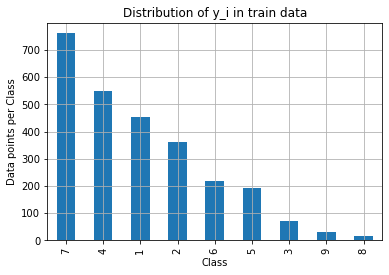

Number of data points in class 1 : 761 ( 28.695 %)
Number of data points in class 2 : 549 ( 20.701 %)
Number of data points in class 3 : 453 ( 17.081 %)
Number of data points in class 4 : 361 ( 13.612 %)
Number of data points in class 5 : 218 ( 8.22 %)
Number of data points in class 6 : 194 ( 7.315 %)
Number of data points in class 7 : 71 ( 2.677 %)
Number of data points in class 8 : 30 ( 1.131 %)
Number of data points in class 9 : 15 ( 0.566 %)
--------------------------------------------------------------------------------


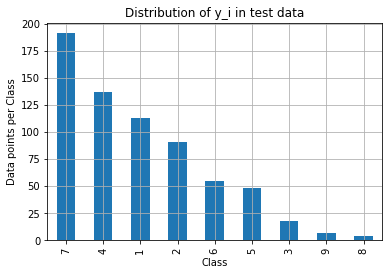

Number of data points in class 1 : 191 ( 28.765 %)
Number of data points in class 2 : 137 ( 20.633 %)
Number of data points in class 3 : 113 ( 17.018 %)
Number of data points in class 4 : 91 ( 13.705 %)
Number of data points in class 5 : 55 ( 8.283 %)
Number of data points in class 6 : 48 ( 7.229 %)
Number of data points in class 7 : 18 ( 2.711 %)
Number of data points in class 8 : 7 ( 1.054 %)
Number of data points in class 9 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


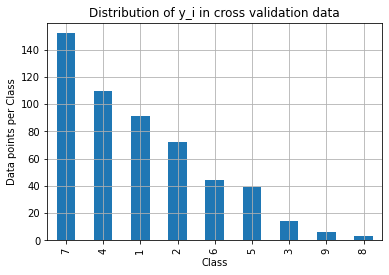

Number of data points in class 1 : 152 ( 28.625 %)
Number of data points in class 2 : 110 ( 20.716 %)
Number of data points in class 3 : 91 ( 17.137 %)
Number of data points in class 4 : 72 ( 13.559 %)
Number of data points in class 5 : 44 ( 8.286 %)
Number of data points in class 6 : 39 ( 7.345 %)
Number of data points in class 7 : 14 ( 2.637 %)
Number of data points in class 8 : 6 ( 1.13 %)
Number of data points in class 9 : 3 ( 0.565 %)


In [9]:
def plot_distribution(class_distribution,title,xlabel,ylabel):
    class_distribution.plot(kind='bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()


# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train['Class'].value_counts()
test_class_distribution = y_tst['Class'].value_counts()
cv_class_distribution = y_cv['Class'].value_counts()

plot_distribution(train_class_distribution,
                 'Distribution of y_i in train data',
                 'Class',
                 'Data points per Class')


# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')
    
print('-'*80)



plot_distribution(test_class_distribution,
                 'Distribution of y_i in test data',
                 'Class',
                 'Data points per Class')

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(test_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          '(', np.round((test_class_distribution.values[i]/x_tst.shape[0]*100), 3), '%)')

print('-'*80)



plot_distribution(cv_class_distribution,
                 'Distribution of y_i in cross validation data',
                 'Class',
                 'Data points per Class')

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(cv_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3), '%)')

### Univariate Analysis On Gene Feature


In [10]:
unique_genes = x_train['Gene'].value_counts()
print(df_final['Gene'].value_counts().head(10)) # 10 most occuring genes 
print('\nTotal Genes Categories :',x_train['Gene'].value_counts().shape[0])

# So total 3316 Gene Values (Catagories) Are There.

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       92
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64

Total Genes Categories : 245


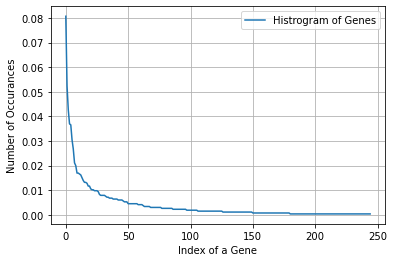

In [11]:
# Distribution Of Gene-Data

s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

In [12]:
# code for response coding with Laplace smoothing.
# feature: ['gene', 'variation']
# df: ['x_train', 'x_tst', 'x_cv']

# Algorithm:
""""
 Consider all unique values and the number of occurances of given feature in train data dataframe
 build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
 gv_dict is like a look up table, for every gene it store a (1*9) representation of it
 for a value of feature in df:
 if it is in train data:
 we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
 if it is not there is train:
 we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
 return 'gv_fea'
 
"""

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = x_train[feature].value_counts()
    gv_dict = dict() #Gene Variation Dict,which contains probability array for each gene
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        vec = [] # 9 diamensional vector
        
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = x_train.loc[(y_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
        
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    # {'BRCA1': [0.200757, 0.037878, 0.06818, 0.136363, 0.25, 0.193181, 0.03787,0.03787,0.03787], 
    # 'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    # ... }
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [13]:
# Response Coding

alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_tst))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [14]:
# one-hot encoding of Gene feature.

gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_tst['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [15]:
print(len(gene_vectorizer.get_feature_names()))

# encoded features

244


### Building Logistic Regression Model Only Using Gene Feature to Estimate how good Gene Feature is in Prediction of y_i.

For values of alpha =  1e-05 The log loss is: 0.9947351291008801
For values of alpha =  0.0001 The log loss is: 0.99767401734262
For values of alpha =  0.001 The log loss is: 1.1119253865629106
For values of alpha =  0.01 The log loss is: 1.2961057770889246
For values of alpha =  0.1 The log loss is: 1.4038639175586294
For values of alpha =  1 The log loss is: 1.4478800330269281


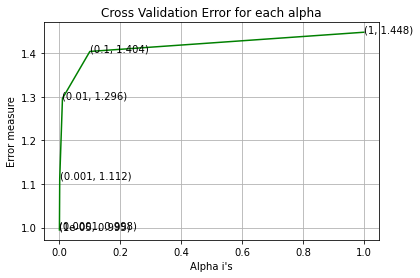

For values of best alpha =  1e-05 The train log loss is: 0.9944303719922394
For values of best alpha =  1e-05 The cross validation log loss is: 0.9947351291008801
For values of best alpha =  1e-05 The test log loss is: 1.1883885804279088


In [16]:
# We're Building Liner Model With Stochastic Gredient Descent
alpha= [10 ** x for x in range(-5,1)] # Hyperparameter For SGD-Classifier


# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# fit(X, y[, coef_init, intercept_init, …])--->Fit linear model with Stochastic Gradient Descent.
# predict(X)--->Predict class labels for samples in X.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
fig.figsize=(20,20)
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))


#### So,  Gene Feature is Stabel Across all Datasets (Train, Test, Validation) Due to Less CV & Test Errors 

#### Univariate Analysis For Variation Feature 

In [17]:
unique_variations = x_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))
print("There are",unique_variations.shape[0],"different categories of variations in the train data",)

Number of Unique Variations : 2400
Truncating Mutations    76
Deletion                58
Amplification           53
Fusions                 27
Overexpression           5
Q61R                     3
E17K                     3
T58I                     3
G12V                     3
Q61H                     3
Name: Variation, dtype: int64
There are 2400 different categories of variations in the train data


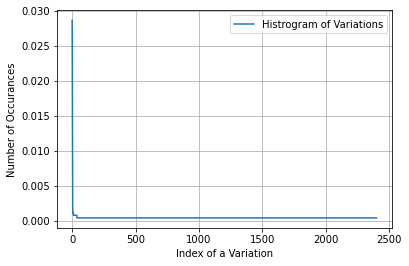

In [18]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02865762 0.0505279  0.07051282 ... 0.99924585 0.99962293 1.        ]


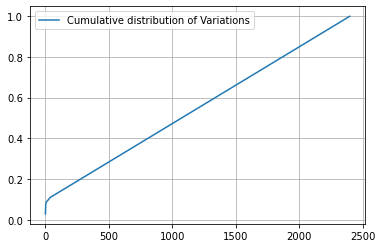

In [19]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [20]:
# response coding for variation feature

alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_tst))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [21]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_tst['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

For values of alpha =  1e-05 The log loss is: 0.5854671188865956
For values of alpha =  0.0001 The log loss is: 0.7009198491506411
For values of alpha =  0.001 The log loss is: 1.162071358621733
For values of alpha =  0.01 The log loss is: 1.5349118860793702
For values of alpha =  0.1 The log loss is: 1.6410800438234505
For values of alpha =  1 The log loss is: 1.6538183798040966


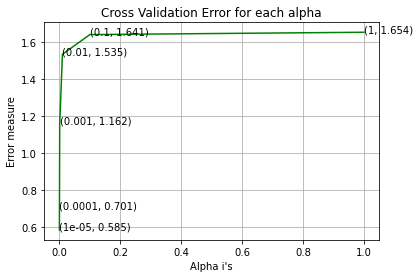

For values of best alpha =  1e-05 The train log loss is: 0.5645463537039729
For values of best alpha =  1e-05 The cross validation log loss is: 0.5854671188865956
For values of best alpha =  1e-05 The test log loss is: 1.6938809465592242


In [22]:
alpha= [10 ** x for x in range(-5,1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))


### Objective of Univariate Analysis on Text Feature¶
#### 1. How many unique words are present in train data?
#### 2.How are word frequencies distributed?
#### 3.How to featurize text field?
#### 4.Is the text feature useful in predicitng y_i?
#### 5.Is the text feature stable across train, test and CV datasets?

In [23]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['text'].split():
            dictionary[word] +=1
    return dictionary

In [24]:
# Response Coding of Text

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [25]:
x_train['text'].head(4)

1962    cervical cancer is responsible for 10 15 of ca...
2760    the ras raf mek map kinase erk signaling pathw...
1145    met proto oncogene receptor tyrosine kinase ge...
2172    the pten phosphatase and tensin homolog phosph...
Name: text, dtype: object

In [26]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df_text = pd.DataFrame(top_feats)
    df_text.columns = ['feature', 'tfidf']
    return df_text

def top_mean_feats(Xtr, features, min_tfidf=0.1, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

#### turning point

In [27]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['text'])

# getting top 1000 feature names (words)
train_text_features = top_mean_feats(train_text_feature_onehotCoding,
                                    text_vectorizer.get_feature_names(),
                                    top_n=1000)     ['feature'].tolist()

len(train_text_features)

1000

In [28]:
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
train_text_fea_counts

array([7.89016153, 8.58993159, 0.0357347 , ..., 0.02885074, 0.02207461,
       0.054422  ])

In [29]:
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [30]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[y_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [31]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_tst)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [32]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [33]:
# Normalizing Every Feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_tst['text'])
# Normalize Feature 
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['text'])
# normalize feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


#https://stackoverflow.com/a/2258273/4084039
# Sorted Dict
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [34]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.023209136191612786: 27, 0.07021739472605032: 15, 0.023677979090529114: 9, 0.029798605517700853: 8, 0.26613505880865956: 6, 0.03837440481917599: 6, 0.02689950460824769: 6, 0.24381798778610642: 4, 0.04735595818105823: 4, 0.03705610747421442: 4, 0.019093800678672654: 4, 0.06647236154655663: 3, 0.057804235107499664: 3, 0.03602417732029009: 3, 0.03242429894898108: 3, 0.029574671667263235: 3, 0.024483643595798903: 3, 0.02267180588361694: 3, 0.016383935337282253: 3, 0.014009263483836017: 3, 0.012838086843866498: 3, 0.0092035576219591: 3, 0.007825559579055924: 3, 0.2496660030502355: 2, 0.07103393727158733: 2, 0.07043003621150332: 2, 0.06917563788747848: 2, 0.06750278309082226: 2, 0.059487215994510054: 2, 0.0547403660723735: 2, 0.04197302056530471: 2, 0.03796892947170154: 2, 0.033259182938834786: 2, 0.03121717186457991: 2, 0.0295258083961075: 2, 0.029086686765769768: 2, 0.02905072919225108: 2, 0.023231572547674034: 2, 0.02276653472124896: 2, 0.021922913446881073: 2, 0.018467506505286

For values of alpha =  1e-05 The log loss is: 0.5921586314828897
For values of alpha =  0.0001 The log loss is: 0.388313941572106
For values of alpha =  0.001 The log loss is: 0.4349272151134774
For values of alpha =  0.01 The log loss is: 0.7336482956996737
For values of alpha =  0.1 The log loss is: 1.0377596185628821
For values of alpha =  1 The log loss is: 1.409940600989775


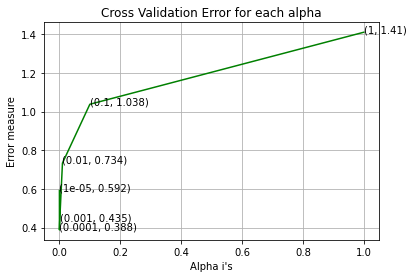

For values of best alpha =  0.0001 The train log loss is: 0.5802919484726494
For values of best alpha =  0.0001 The cross validation log loss is: 0.388313941572106
For values of best alpha =  0.0001 The test log loss is: 1.0651322716870693


In [35]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)] # Hyperparameter

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))


#### So, We Can Use Text Feature For Further Modeling

In [36]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['text'])   
    
    df_text_features = top_mean_feats(df_text_fea,
                                      df_text_vec.get_feature_names(),
                                      top_n=1000)['feature'].tolist()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [37]:
len1,len2 = get_intersec_text(x_tst)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

56.7 % of word of test data appeared in train data
62.1 % of word of Cross Validation appeared in train data


## Machine Learning Models

In [38]:
#Data preparation for ML models.
#Miscellaneous functionns for ML models.

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)


# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [39]:
# this function will be used just for naive bayes
""" 
for the given indices, we will print the name of the features
and we will check whether the feature present in the test point text or not
"""

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:            
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking Features

In [40]:
# merging gene, variance and text features
"""
building train, test and cross validation data sets
a = [[1, 2], 
    [3, 4]]
      
b = [[4, 5], 
    [6, 7]]
      
hstack(a, b)= [[1, 2, 4, 5],
              [ 3, 4, 6, 7]]
"""

# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_tst['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [41]:
print("One hot encoding features :")
print("(number of data points, number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points, number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points, number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points, number of features) in train data =  (2652, 62620)
(number of data points, number of features) in test data =  (664, 62620)
(number of data points, number of features) in cross validation data = (531, 62620)


### 1.1 Base-Line Model
#### 1.1.1 Naive-Bayes Model

In [42]:
# HyperParameter Tuning

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]

cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))


In [43]:
# Model With Best Parameter

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Correctly classified point

In [44]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
print(get_impfeature_names(indices[0], 
                     x_tst['text'].iloc[test_point_index],
                     x_tst['Gene'].iloc[test_point_index],
                     x_tst['Variation'].iloc[test_point_index], 
                     no_feature))

#### Incorrectly Classified Point

In [45]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_tst['text'].iloc[test_point_index],
                     x_tst['Gene'].iloc[test_point_index],
                     x_tst['Variation'].iloc[test_point_index], no_feature)

### 1.1.2 K Nearest Neighbour Classification

In [46]:
# HyperParameter Tuning 

neighbors = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in neighbors:
    print("for neighbors =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_neighbors = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=neighbors[best_neighbors])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))


In [47]:
clf = KNeighborsClassifier(n_neighbors=neighbors[best_neighbors])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [48]:
clf = KNeighborsClassifier(n_neighbors=neighbors[best_neighbors])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 12
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbors[best_neighbors])
print("The ",neighbors[best_neighbors]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

### Logistic Regression With Class balancing

for alpha = 1e-06
Log Loss : 0.959853919813916
for alpha = 1e-05
Log Loss : 0.9351718181104619
for alpha = 0.0001
Log Loss : 0.9225344368115318
for alpha = 0.001
Log Loss : 0.9941484427595569
for alpha = 0.01
Log Loss : 1.2042835378385226
for alpha = 0.1
Log Loss : 1.6421708739180159
for alpha = 1
Log Loss : 1.7928439725476082
for alpha = 10
Log Loss : 1.802318382247547
for alpha = 100
Log Loss : 1.8031432655741404


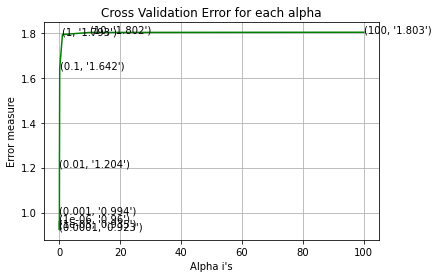

For values of best alpha =  0.0001 The train log loss is: 0.389519854561465
For values of best alpha =  0.0001 The cross validation log loss is: 0.9225344368115318


ValueError: Found input variables with inconsistent numbers of samples: [366, 664]

In [137]:
# HyperParameter Tuning
"""
--->Balanced Class:
The "balanced" mode uses the values of y to automatically adjust
weights inversely proportional to class frequencies in the input data
as ``n_samples / (n_classes * np.bincount(y)
"""

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))

In [50]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [51]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [52]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_,kind='heap')[predicted_cls-1][:,:no_feature]
# print("-"*50)
# get_impfeature_names(indices[0], x_tst['text'].iloc[test_point_index],
#                      x_tst['Gene'].iloc[test_point_index],
#                      x_tst['Variation'].iloc[test_point_index], 
#                      no_feature)

### Logistic Regression Without Class balancing

In [53]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))

In [54]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# Random Forest Classifier
#### 1.1 Hyper paramter tuning (With One hot Encoding)

In [55]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 15]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))

In [56]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Linear Support Vector Machine
##### We Can Use SVC With SGD-Classifier By Using Hinge Loss (as loss Parameter) and l2 Penalty (as penalty parameter).

In [57]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))

In [58]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Stack the models
#### 1.1 HyperParameter Tuning

In [128]:
# HyperParameter Tuning

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.000001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10,15] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.99
Support vector machines : Log Loss: 1.27
Naive Bayes : Log Loss: 1.13
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.822
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.692
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.253
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.104
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.456
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.027
Stacking Classifer : for the value of alpha: 15.000000 Log Loss: 2.149


#### 1.2 testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.3196691642310465
Log loss (CV) on the stacking classifier : 1.1043271169612323
Log loss (test) on the stacking classifier : 1.0703707414535604
Number of missclassified point : 0.32786885245901637
-------------------- Confusion matrix --------------------


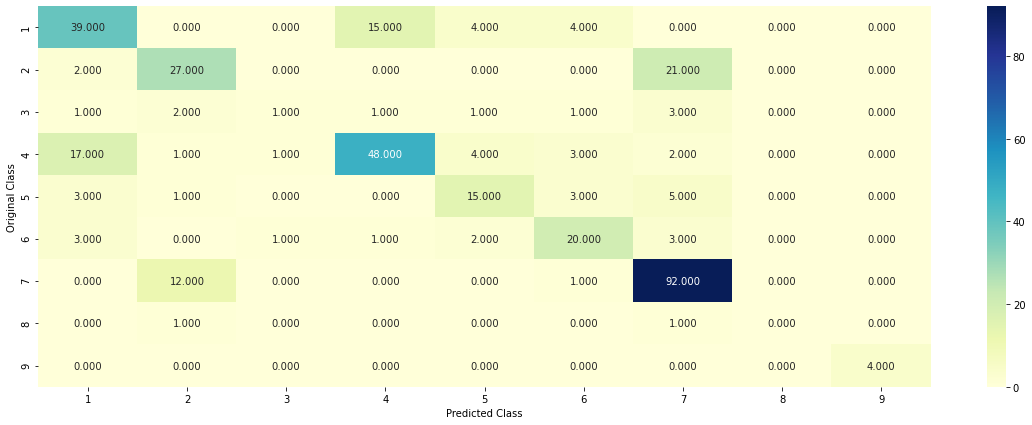

-------------------- Precision matrix (Columm Sum=1) --------------------


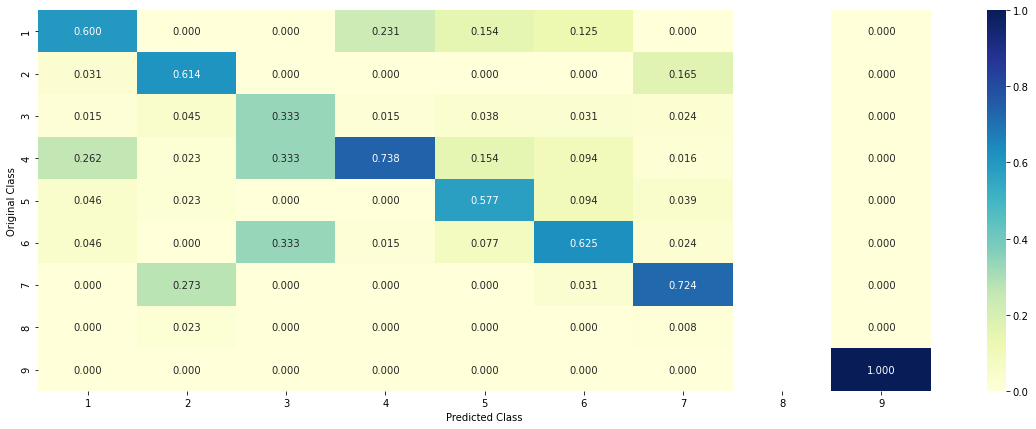

-------------------- Recall matrix (Row sum=1) --------------------


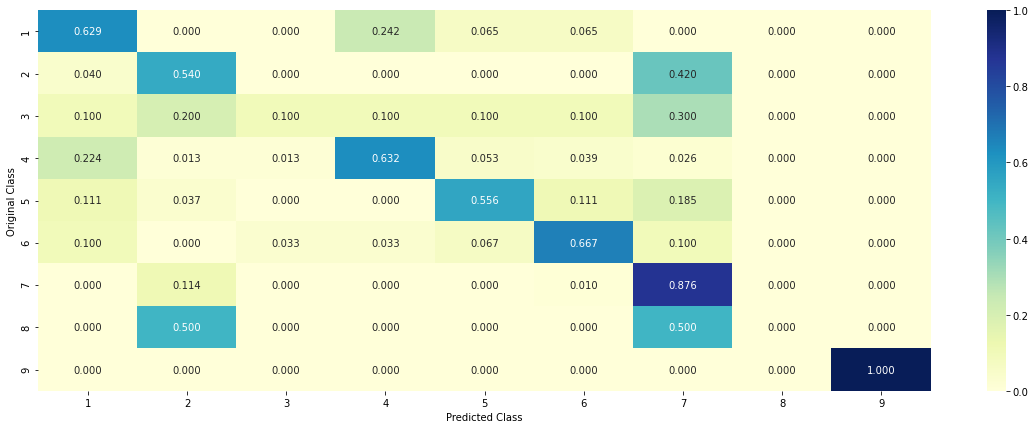

In [129]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)
log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)
log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)
print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximum Voting classifier 

In [131]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
# plot_confusion_matrix(test_y=tst_y, predict_y=vclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.710901571396047
Log loss (CV) on the VotingClassifier : 1.0730793048467957
Log loss (test) on the VotingClassifier : 1.0723996775596023
Number of missclassified point : 0.3333333333333333


### Logistic regression with CountVectorizer(unigrams & bigrams)
#### 1.1 Gene Feature

In [61]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_tst))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [62]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(ngram_range=(1, 2))
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_tst['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

# don't forget to normalize every feature
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

#### 1.2 Variation Feature

In [63]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_tst))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [64]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(ngram_range=(1, 2))
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_tst['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])


# don't forget to normalize every feature
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)

#### 1.3 Text Feature

In [65]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['text'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 782839


In [66]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_tst)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [68]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_tst['text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

### 1.4 Stack above three features

In [69]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_tst['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [70]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2652, 785712)
(number of data points * number of features) in test data =  (664, 785712)
(number of data points * number of features) in cross validation data = (531, 785712)


In [71]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2652, 27)
(number of data points * number of features) in test data =  (664, 27)
(number of data points * number of features) in cross validation data = (531, 27)


### Logistic Regression

for alpha = 1e-06
Log Loss : 1.051011877246068
for alpha = 1e-05
Log Loss : 1.0019259935562137
for alpha = 0.0001
Log Loss : 0.7421429612437813
for alpha = 0.001
Log Loss : 0.42217634944663707
for alpha = 0.01
Log Loss : 0.46881121812563253
for alpha = 0.1
Log Loss : 0.688631410712393
for alpha = 1
Log Loss : 1.1096835710146071
for alpha = 10
Log Loss : 1.32990370923402
for alpha = 100
Log Loss : 1.3626761833418874


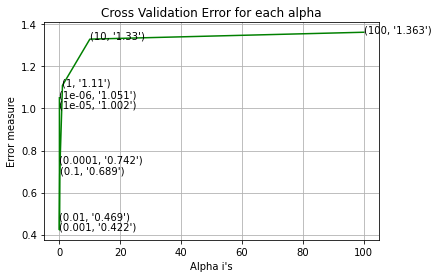

For values of best alpha =  0.001 The train log loss is: 0.6622949918806537
For values of best alpha =  0.001 The cross validation log loss is: 0.42217634944663707
For values of best alpha =  0.001 The test log loss is: 1.1147699090597456


In [73]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_tst, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.42217634944663707
Number of mis-classified points : 0.12429378531073447
-------------------- Confusion matrix --------------------


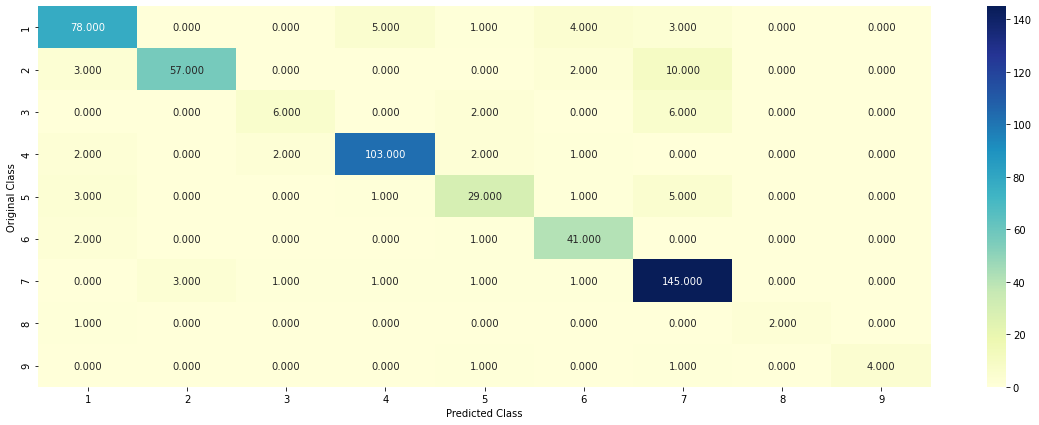

-------------------- Precision matrix (Columm Sum=1) --------------------


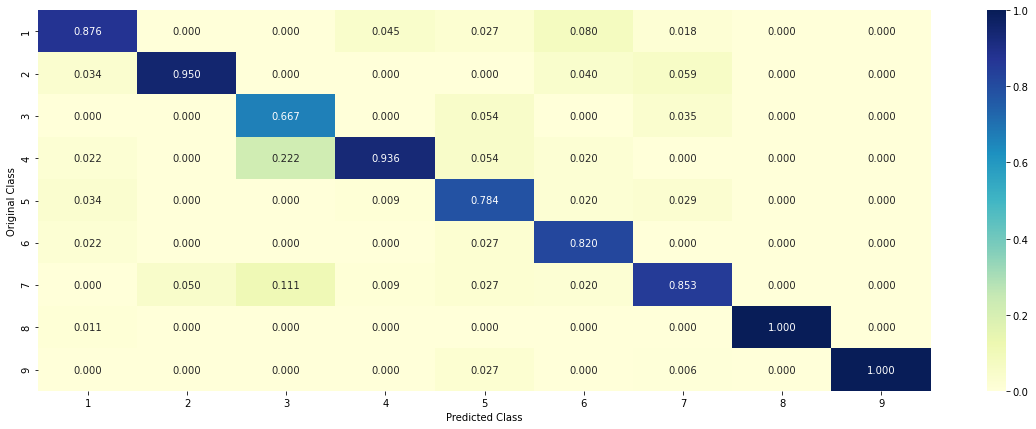

-------------------- Recall matrix (Row sum=1) --------------------


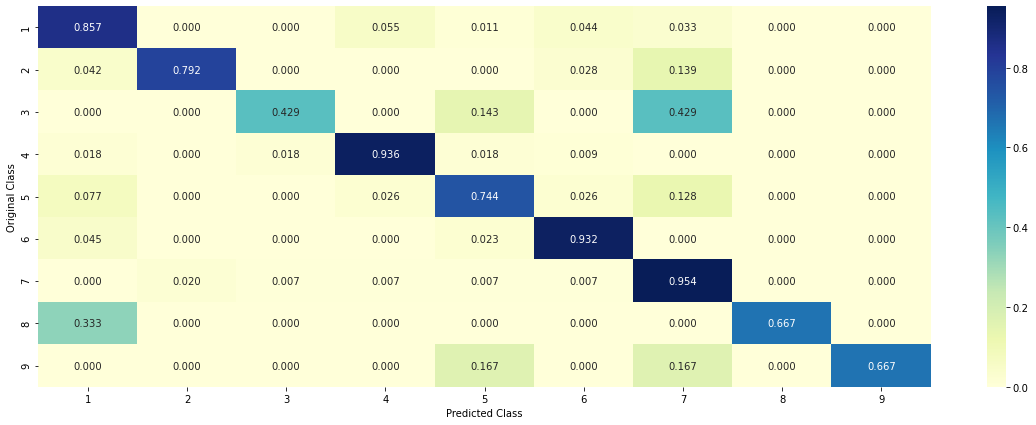

In [74]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

The log loss doesn't decreases much using unigram and bigram.

#### Merging gene and variation data into one list and apply TFidfVectorizer on top of it.

Gene Feature

In [80]:
result = pd.merge(df_variants, df_txt,on='ID', how='left')
result.loc[result['text'].isnull(),'text'] = result['Gene'] +' '+result['Variation']
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

x_train, x_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.11)

x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.11)

In [82]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = x_train[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)   
    value_count = x_train[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [83]:
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [85]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [87]:
print(train_gene_feature_onehotCoding.shape)
print(test_gene_feature_onehotCoding.shape)
print(cv_gene_feature_onehotCoding.shape)

(2629, 245)
(366, 245)
(326, 245)


#### Variation Feature

In [88]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [89]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [90]:
print(train_variation_feature_onehotCoding.shape)
print(test_variation_feature_onehotCoding.shape)
print(cv_variation_feature_onehotCoding.shape)

(2629, 2430)
(366, 2430)
(326, 2430)


#### Text Feature


In [102]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['text'].split():
            dictionary[word] +=1
    return dictionary

import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [103]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer()
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 138310


In [104]:
print(train_text_feature_onehotCoding.shape)

(2629, 138310)


In [105]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(x_train)
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)


#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

#### Features after feature engineering

In [108]:
# Collecting all the genes and variations data into a single list
gene_variation = []

for gene in df_variants['Gene'].values:
    gene_variation.append(gene)

for variation in df_variants['Variation'].values:
    gene_variation.append(variation)

In [109]:
# tfidfVectorizer
tfidfVectorizer = TfidfVectorizer(max_features=1000)
text2 = tfidfVectorizer.fit_transform(gene_variation)
gene_variation_features = tfidfVectorizer.get_feature_names()

train_text = tfidfVectorizer.transform(x_train['text'])
test_text = tfidfVectorizer.transform(x_test['text'])
cv_text = tfidfVectorizer.transform(x_cv['text'])

In [110]:
print(train_text.shape)
print(test_text.shape)
print(cv_text.shape)

test_text_feature_onehotCoding = text_vectorizer.transform(x_test['text'])
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['text'])
print(train_text_feature_onehotCoding.shape )
print(test_text_feature_onehotCoding.shape )
print(cv_text_feature_onehotCoding.shape )

(2629, 1000)
(366, 1000)
(326, 1000)
(2629, 138310)
(366, 138310)
(326, 138310)


#### Stacking above three features

In [114]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

# Adding the train_text feature
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text))
train_x_onehotCoding = hstack((train_x_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

# Adding the test_text feature
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text))
test_x_onehotCoding = hstack((test_x_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

# Adding the cv_text feature
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text))
cv_x_onehotCoding = hstack((cv_x_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

print("One hot encoding features :")
print("(number of data points,number of features) in train data=", train_x_onehotCoding.shape)
print("(number of data points,number of features) in test data=", test_x_onehotCoding.shape)
print("(number of data points,number of features) in cross validation data=", cv_x_onehotCoding.shape)

print(" Response encoding features :")
print("(number of data points,number of features) in train data=", train_x_responseCoding.shape)
print("(number of data points,number of features) in test data=", test_x_responseCoding.shape)
print("(number of data points,number of features) in cross validation data=", cv_x_responseCoding.shape)

One hot encoding features :
(number of data points,number of features) in train data= (2629, 141985)
(number of data points,number of features) in test data= (366, 141985)
(number of data points,number of features) in cross validation data= (326, 141985)
 Response encoding features :
(number of data points,number of features) in train data= (2629, 27)
(number of data points,number of features) in test data= (366, 27)
(number of data points,number of features) in cross validation data= (326, 27)


###  LR + FE + Tfidf (Response Coding)

for alpha = 1e-06
Log Loss : 1.090223274360437
for alpha = 1e-05
Log Loss : 1.0297166927213448
for alpha = 0.0001
Log Loss : 1.0811619921663427
for alpha = 0.001
Log Loss : 1.162425060905402
for alpha = 0.01
Log Loss : 1.2170149946501942
for alpha = 0.1
Log Loss : 1.2301281481115482
for alpha = 1
Log Loss : 1.2739459116205898
for alpha = 10
Log Loss : 1.4509942681209083
for alpha = 100
Log Loss : 1.5105277107399648


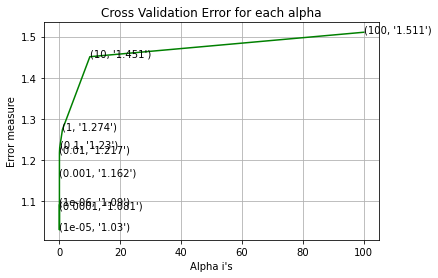

For values of best alpha =  1e-05 The train log loss is: 0.6423227973814851
For values of best alpha =  1e-05 The cross validation log loss is: 1.0376500126653558
For values of best alpha =  1e-05 The test log loss is: 1.047484546750405


In [115]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=60)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0376500126653558
Number of mis-classified points : 0.37116564417177916
-------------------- Confusion matrix --------------------


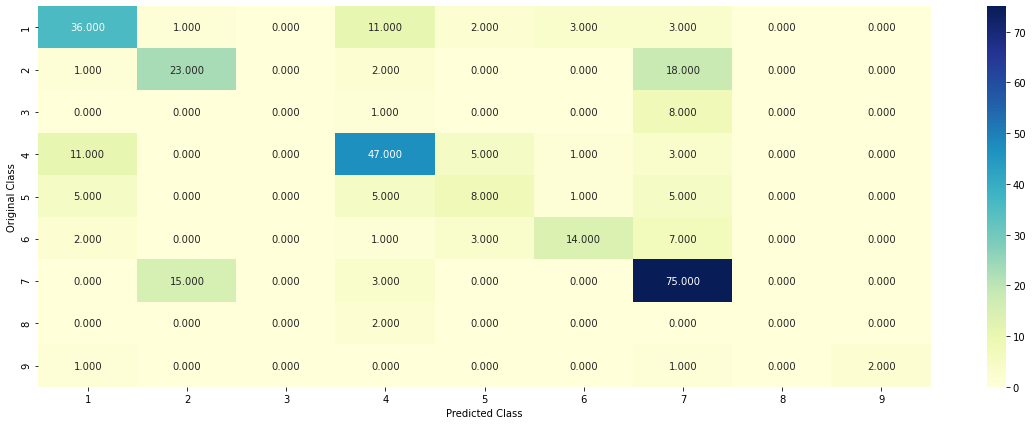

-------------------- Precision matrix (Columm Sum=1) --------------------


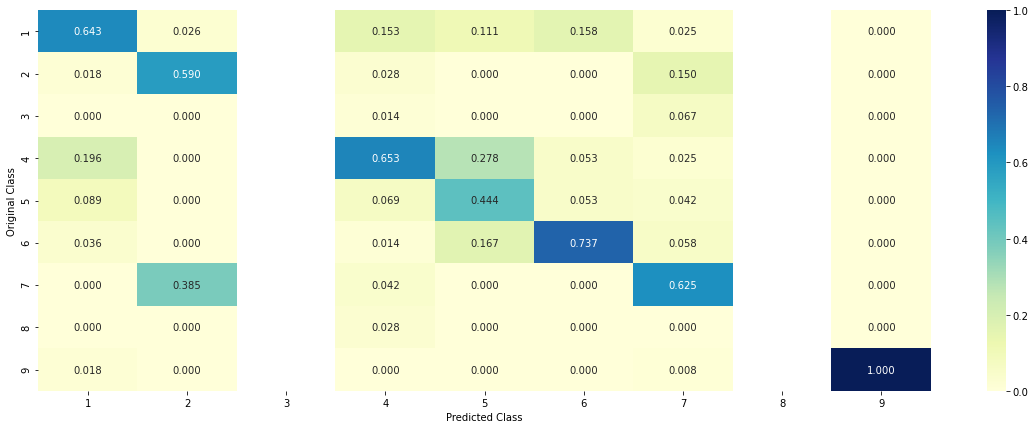

-------------------- Recall matrix (Row sum=1) --------------------


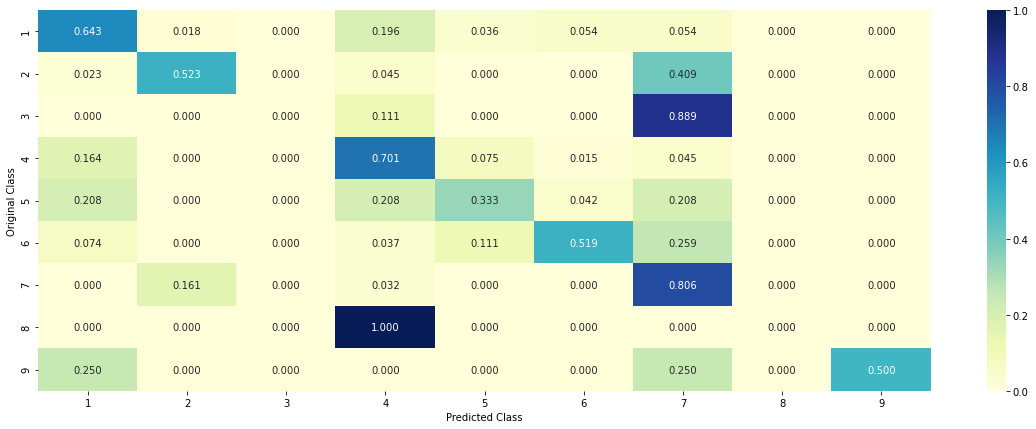

In [116]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### LR + FE + Tfidf (One Hot Encoding)

for alpha = 1e-08
Log Loss : 0.9698343700665824
for alpha = 1e-07
Log Loss : 0.9777542076668453
for alpha = 1e-06
Log Loss : 0.9587570193160556
for alpha = 1e-05
Log Loss : 0.925918596165823
for alpha = 0.0001
Log Loss : 0.9202327615424408
for alpha = 0.001
Log Loss : 0.9940721939214366
for alpha = 0.01
Log Loss : 1.204302576706711
for alpha = 0.1
Log Loss : 1.6421020391370778
for alpha = 1
Log Loss : 1.7927966814644603
for alpha = 10
Log Loss : 1.8023044158533768
for alpha = 100
Log Loss : 1.8031372247382278
for alpha = 1000
Log Loss : 1.8032433777160102


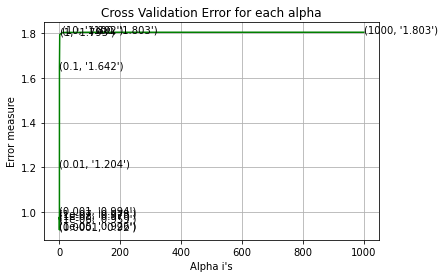

For values of best alpha =  0.0001 The train log loss is: 0.389519854561465
For values of best alpha =  0.0001 The cross validation log loss is: 0.9225344368115318
For values of best alpha =  0.0001 The test log loss is: 0.969764838650529


In [138]:
alpha = [10 ** x for x in range(-8, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=60)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Feature Engineering gives the log loss less than 1 for test and cross validation data.

Log loss : 0.9747896188477445
Number of mis-classified points : 0.3374233128834356
-------------------- Confusion matrix --------------------


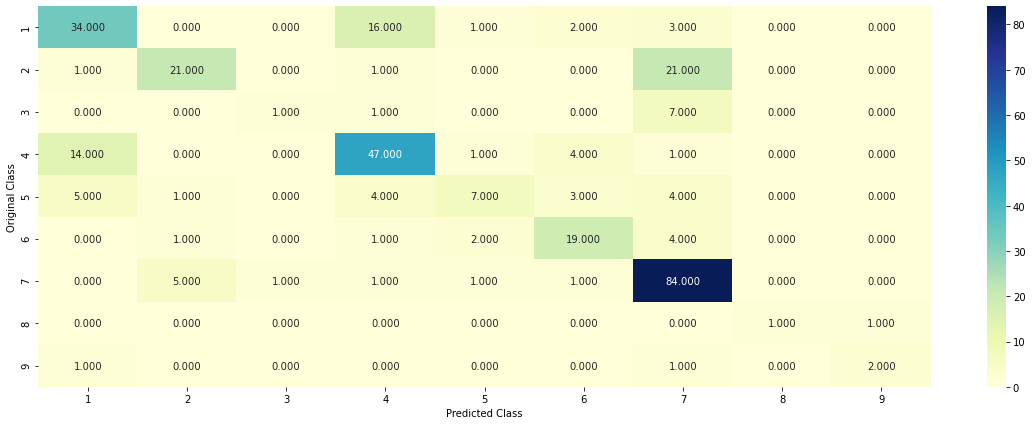

-------------------- Precision matrix (Columm Sum=1) --------------------


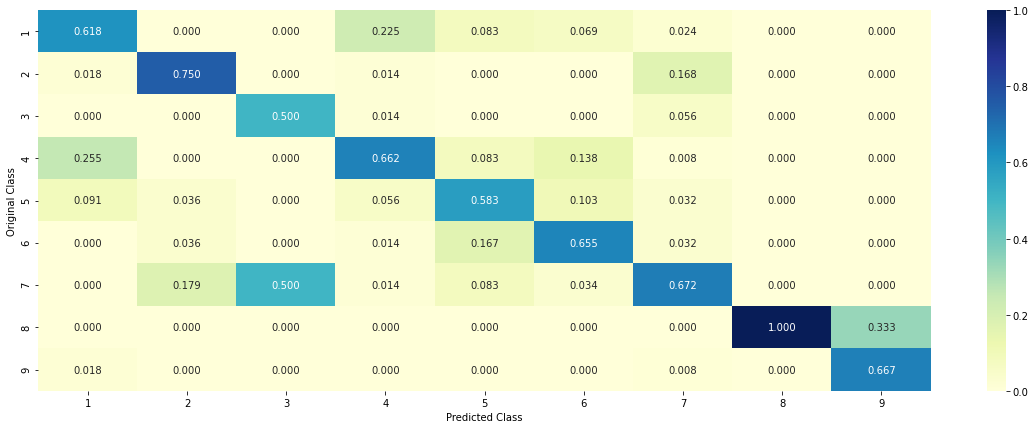

-------------------- Recall matrix (Row sum=1) --------------------


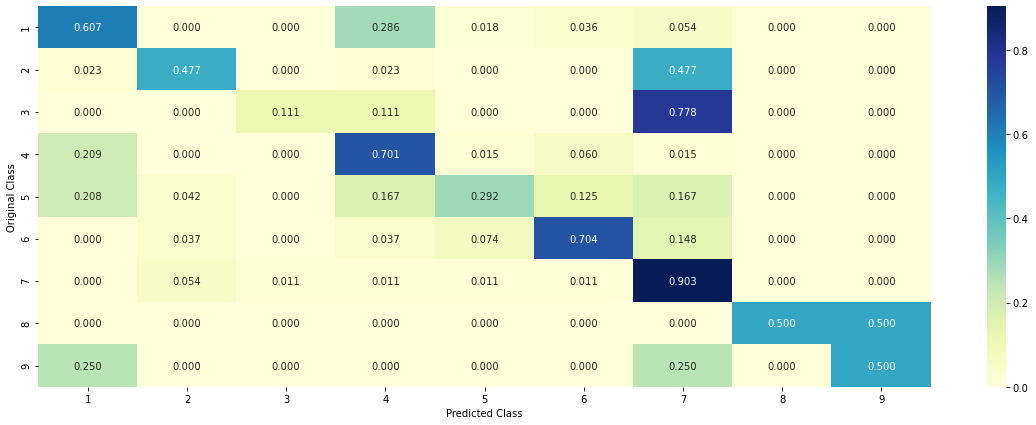

In [136]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Conclusion -
### In this case study following steps have been followed-
#### 1) Loaded the Variant data which contains genes ,variation and the class which it belong to.
#### 2) Loaded the Text data.
#### 3) Our objective was to create a model, such that when gene,variation and text is given we have to predict to which class it belongs.
#### 4) So we merge both variant data and text data into one.
#### 5) We build a random model and get a log loss of approx. 2.2 so we get a threshold so that any model we make must be better than this random model.
#### 6) The we did a Univariate Analysis of our three features -
##### a) Variation
##### b)Gene
##### c)Text
#### To find out whether our feature are useful or not? Now how to find this? We use a simple hack to build a model on each model seperately and we find out that they are useful. (Text feature being the most important).
#### 7) We use two techniques of featurization a). One hot Encoding and b).Response Coding.
#### 9) Then we stacked all our 3 features into one.
#### 10) We Build various models- Naive Bayes, KNN, Logistic Regression, Linear SVM,Random Forest, Stacking Model and Maximum Voting Classifier, for above models we get quite good results with logistic regression with log loss for test data near to 1.12.
#### 11) Now we want to know, If our models can improve any more??
#### 12) We tried featurization both with unigram and bigram, but we get not so satisfying result.
#### 13) Then We tried Feature Engineering that is combining Gene and Variation  into one list and applying Logistic Regression on both One Hot Encoding and Response Encoding.¶
#### 14) Yes! it works, we were able to bring down our log loss to 0.95 for test data using LR+FE+OnehotEncoding on TFIDF dataset.

### Pretty table
#### without Feature Engineering

In [125]:
print()
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "*** Model Summary *** "
ptable.field_names=["Model Name","Train Log-Loss","CV Log-Loss","Test Log-Loss","% Misclassified Points"]
ptable.add_row(["Naive Bayes","0.91","1.20","1.20","36"])
ptable.add_row(["KNN","0.65","1.09","1.05","36.6"])
ptable.add_row(["LR With Class balancing","0.52","1.08","1.08","35.03"])
ptable.add_row(["LR Without Class balancing","0.51","1.10","1.09","37.06"])
ptable.add_row(["Linear SVM","0.56","1.10","1.14","37.02"])
ptable.add_row(["RF With One hot Encoding","0.65","1.15","1.13","44.10"])
ptable.add_row(["RF With Response Coding","0.04","1.26","1.26","44.26"])
ptable.add_row(["Stack Models:LR+NB+SVM","0.55","1.55","1.14","35.68"])
ptable.add_row(["Maximum Voting classifier","0.65","1.09","1.16","36.53"])
# ptable.padding_width =1
print(ptable)


+----------------------------------------------------------------------------------------------------+
|                                       *** Model Summary ***                                        |
+----------------------------+----------------+-------------+---------------+------------------------+
|         Model Name         | Train Log-Loss | CV Log-Loss | Test Log-Loss | % Misclassified Points |
+----------------------------+----------------+-------------+---------------+------------------------+
|        Naive Bayes         |      0.91      |     1.20    |      1.20     |           36           |
|            KNN             |      0.65      |     1.09    |      1.05     |          36.6          |
|  LR With Class balancing   |      0.52      |     1.08    |      1.08     |         35.03          |
| LR Without Class balancing |      0.51      |     1.10    |      1.09     |         37.06          |
|         Linear SVM         |      0.56      |     1.10    |      1.14 

#### With Feature Engineering

In [139]:
ptable1 = PrettyTable()
ptable1.field_names=["Model Name","Train Log-Loss","CV Log-Loss","Test Log-Loss","% Misclassified Points"]
ptable1.add_row(["LR with Response Coding","0.62","1.06","1.11","16.4"])
ptable1.add_row(["LR with one hot encoding","0.38","0.92","0.96","16.4"])
print(ptable1)

+--------------------------+----------------+-------------+---------------+------------------------+
|        Model Name        | Train Log-Loss | CV Log-Loss | Test Log-Loss | % Misclassified Points |
+--------------------------+----------------+-------------+---------------+------------------------+
| LR with Response Coding  |      0.62      |     1.06    |      1.11     |          16.4          |
| LR with one hot encoding |      0.38      |     0.92    |      0.96     |          16.4          |
+--------------------------+----------------+-------------+---------------+------------------------+


## Hence, the best model is Logistic Regression with Feature Engineering(One Hot Encoding). And maximum accuracy obtain is 84.6%.